# CSI 4106 Introduction to Artificial Intelligence 
## Assignment 3: Neural Networks

## Report Title: Implementing Neural Networks, Tuning Hyperparameters and Evaluating Models for Machine Learning

### Identification

Name: Alex Govier <br/>
Student Number: 300174954

#### Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.model_selection import cross_validate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

### Exploratory Analysis

#### 1. Loading Dataset and Summary

In [2]:
# Loading the three datasets from my GitHub
test = "https://github.com/alex-govier5/intro-to-ai/raw/master/A3/cb513_test.csv"
test_set = pd.read_csv(test)

train = "https://github.com/alex-govier5/intro-to-ai/raw/master/A3/cb513_train.csv"
training_set = pd.read_csv(train)

valid = "https://github.com/alex-govier5/intro-to-ai/raw/master/A3/cb513_valid.csv"
valid_set = pd.read_csv(valid)

Here I load my data sets and can see that the training set includes 58,291 examples, the validation set contains 7,409 examples, and the test set has 7,432 examples. The target variable in the first column, can take on one of three values: 0, 1, or 2. The remaining 462 columns represent attributes, which are numerical values ranging from 0 to 1.

#### 2. Shuffling the Rows
Here I will shuffle my rows to mitigate the potential negative impact on model training.

In [3]:
# Shuffling the rows of the datasets
test_set = test_set.sample(frac=1).reset_index(drop=True)
training_set = training_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

The frac=1 part means that 100% of the data is being shuffled. The reset_index makes sure that the index is reset after shuffling. So this should help with the adjacent examples problem.

#### 3. Isolating the Target and the Data
Here I will isolate the target and separate it from the features before I scale any features so that the target variable does not get scaled.

In [4]:
# Separate features (X) and target (y) for training set
y_train = training_set.iloc[:, 0]     # Only the first column
X_train = training_set.iloc[:, 1:]    # All columns except the first

# Separate features (X) and target (y) for validation set
y_valid = valid_set.iloc[:, 0]        # Only the first column
X_valid = valid_set.iloc[:, 1:]       # All columns except the first

# Separate features (X) and target (y) for test set
y_test = test_set.iloc[:, 0]          # Only the first column
X_test = test_set.iloc[:, 1:]         # All columns except the first

So the three datasets are now separated into the features (x) and the target (y).

#### 4. Scaling the Numerical Features
Here I will scale my features for my datasets so that it will act as an experiment I can use later on to compare performance with.

In [33]:
# Scaling the train features to use as experiment later on
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.fit_transform(X_test)

So here I use the min max scaler to fit transform my dataset features. Since they contain all my columns, the scaling will be applied uniformly across all columns. I will use these scaled sets later on to see if it improves any performance.

#### 5. Model Development
Here I will initialize my three models.

In [6]:
# Dummy model that predicts the majority class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Baseline model, logistic regression
baseline_clf = LogisticRegression(max_iter=200)
baseline_clf.fit(X_train, y_train)

# Neural network 
nn_model = Sequential([
    Input(shape=(462,)),             # Input layer
    Dense(8),                        # Hidden layer with 8 nodes
    Dense(3, activation='softmax')   # Output layer with 3 nodes for 3 classes
])

Here I implement my dummy model which will predict the majority class. Then I chose to implement logistic regression because it tends to work well with high dimensionality which my datasets have, it uses probabilistic interpretation, so it provides a natural way to interpret the likelihood of each structure. It can handle scaled data well which will be useful for my scaled dataset experiment, and it is a relatively simple model that is fast to train, I set an initial max iterations of 200 to ensure convergence, I will try different values later on. I then implement the neural network with tensorflow and keras, with an input layer with 462 nodes, then the hidden layer with 8 nodes and the default activation function (so not specified) and finally the output layer with 3 nodes using the softmax activation function. So my three models are setup for training.

#### 6. Model Evaluation
Here I will evaluate my initial models, with a basic predict and classification report for the dummy model, with cross validation (with precision, recall and F1) for the baseline, and using the validation set and a classification report for the neural network.

In [9]:
# Dummy model
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_valid)
print("Dummy Model:")
print(classification_report(y_valid, dummy_preds, zero_division=0))

# Baseline model
scoring_metrics = ['precision_macro', 'recall_macro', 'f1_macro']

# Use cross_validate to compute multiple metrics
cv_results = cross_validate(baseline_clf, X_train, y_train, cv=3, scoring=scoring_metrics)

# Extract scores for each metric
precision_scores = cv_results['test_precision_macro']
recall_scores = cv_results['test_recall_macro']
f1_scores = cv_results['test_f1_macro']

# Display the results
print(f"Baseline Model Cross-Validation Precision Scores: {precision_scores}")
print(f"Baseline Model Mean Precision Score: {precision_scores.mean()}")

print(f"Baseline Model Cross-Validation Recall Scores: {recall_scores}")
print(f"Baseline Model Mean Recall Score: {recall_scores.mean()}")

print(f"Baseline Model Cross-Validation F1 Scores: {f1_scores}")
print(f"Baseline Model Mean F1 Score: {f1_scores.mean()} \n")

# Neural network
print("Neural Network:")
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))  # Modify epochs based on time/needs
nn_preds = nn_model.predict(X_valid)
nn_preds_classes = nn_preds.argmax(axis=1)
print(classification_report(y_valid, nn_preds_classes))

Dummy Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2490
           1       0.00      0.00      0.00      1808
           2       0.42      1.00      0.59      3110

    accuracy                           0.42      7408
   macro avg       0.14      0.33      0.20      7408
weighted avg       0.18      0.42      0.25      7408

Baseline Model Cross-Validation Precision Scores: [0.67698222 0.67554449 0.68121091]
Baseline Model Mean Precision Score: 0.6779125375473746
Baseline Model Cross-Validation Recall Scores: [0.65643841 0.65862082 0.6647833 ]
Baseline Model Mean Recall Score: 0.6599475102661665
Baseline Model Cross-Validation F1 Scores: [0.6630615  0.66445401 0.67059224]
Baseline Model Mean F1 Score: 0.6660359137326636 

Neural Network:
Epoch 1/5
1822/1822 [==============================] - 2s 842us/step - loss: 0.8008 - accuracy: 0.6546 - val_loss: 0.7703 - val_accuracy: 0.6697
Epoch 2/5
1822/1822 [===================

So here I do an early evaluation of my models which I will aim to improve upon in the upcoming sections. I used the basic predict method for my dummy classifier, and as expected it performed quite poorly, with an overall accuracy of 0.42, and precision, recall and F1 score of 0.14, 0.44 and 0.2 respectively for the macro averages. </br>
I used cross validation for my baseline model, I used 3 folds as instructed to prevent excessive computational demands, and used the precision, recall and F1 scores as metrics. It performed decently well with a mean precision score of 0.68, a mean recall score of 0.66, and a mean F1 score of 0.66 as well. I will aim to improve this score with a grid search in the next section. </br>
I then evaluated my initial neural network, I compiled the model with the adam optimizer (it adjusts learning rates during training to help convergence), I used the sparse categorical cross entropy for the loss function because it suits my problem where each class is represented by an integer, and I used accuracy as a metric. I then train my model with the training set and use 5 epochs to begin with (which I will increase in later sections), I also make sure to use my validation dataset for the validation data. I then create the prediction with my validation data and then extract my predicted classes. In the report, I can see my neural network performed decently well initially, with an accuracy of 0.67, a macro average precision, recall and F1 scores of 0.66, 0.65 and 0.65 respectively. So there is definitely room for improvement but this is a solid starting point. I can see that my neural network may be slightly outperforming my baseline model if also looking at the weighted averages for precision, recall and F1, but this will be updated in later sections.

#### 7. Baseline Model
In this section, I will aim to improve the performance of my baseline model so that it can serve as a better comparison for my neural network later on, I will use grid search to optimize my parameters.

In [27]:
# Define hyperparameter grid for LogisticRegression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Options for regularization
    'max_iter': [100, 200, 500],                    # Number of iterations
    'tol': [1e-4, 1e-3, 1e-2]                       # Tolerance for stopping criteria
}

# Initialize the baseline model
baseline_clf = LogisticRegression(solver='saga')  

# Dictionary to store the best performance metrics
best_performance_results = []

# Use GridSearchCV to perform hyperparameter tuning with cross-validation
grid_search = GridSearchCV(
    estimator=baseline_clf,
    param_grid=param_grid,
    scoring=['precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=False,
    refit='f1_macro',    
    cv=5,                
    n_jobs=-1            
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)

# Detailed results for each metric
results = grid_search.cv_results_
precision_scores = results['mean_test_precision_macro']
recall_scores = results['mean_test_recall_macro']
f1_scores = results['mean_test_f1_macro']

best_precision = np.nanmax(precision_scores)
best_recall = np.nanmax(recall_scores)
best_f1 = np.nanmax(f1_scores)

# Print the results
print("Best Precision Score:", best_precision)
print("Best Recall Score:", best_recall)
print("Best F1 Score:", best_f1)

# Best model after tuning
best_baseline_clf = grid_search.best_estimator_

Best Hyperparameters: {'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}
Best Precision Score: 0.6786111534161883
Best Recall Score: 0.660243104748905
Best F1 Score: 0.6664278982047532


Here I setup a parameter grid, focusing on the penalty, max iterations and tol, I then reinitialize my baseline model with the saga solver. Then I implement the grid search with my baseline classifier, my parameter grid, my scoring which covers precision, recall and F1, and has 5 folds. I then determine the best parameters which in this case was a max iterations of 100, so a low max iteration count can be good so that the model converges early. The penalty was l1, it can be optimal for models because it introduces sparsity in the model's coefficients. And the tol of 0.01, means that a higher tolerance can result in faster convergence by allowing the model to stop optimizing earlier, as long as the weight adjustments are small enough. This might be beneficial for preventing overfitting, especially if the changes are no longer meaningfully improving the model's performance. I was then able to see my best precision, recall and F1 scores across all my folds and configurations. The best precision score was 0.679, which is a slight improvement over the previous result of 0.676. The best recall score was 0.660 which is also a slight improvement over the original 0.658. And the best F1 score is 0.666, another slight improvement over the original score of 0.664. So even though the scores did not improve greatly for now, we will see how my best baseline estimator will perform on the test set later on versus my neural network.

#### 8. Neural Network
Here I will tune my neural network by focusing on different hyperparameters with the aim of getting better performance. First I will define a helper function to help me plot the loss and accuracy.

In [9]:
def plot_loss_accuracy(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


I will call this function whenever I will need to plot the results to see how my model is performing. Now I can continue on to the experiment, starting with varying the number of nodes.


Training with 1 nodes in the hidden layer


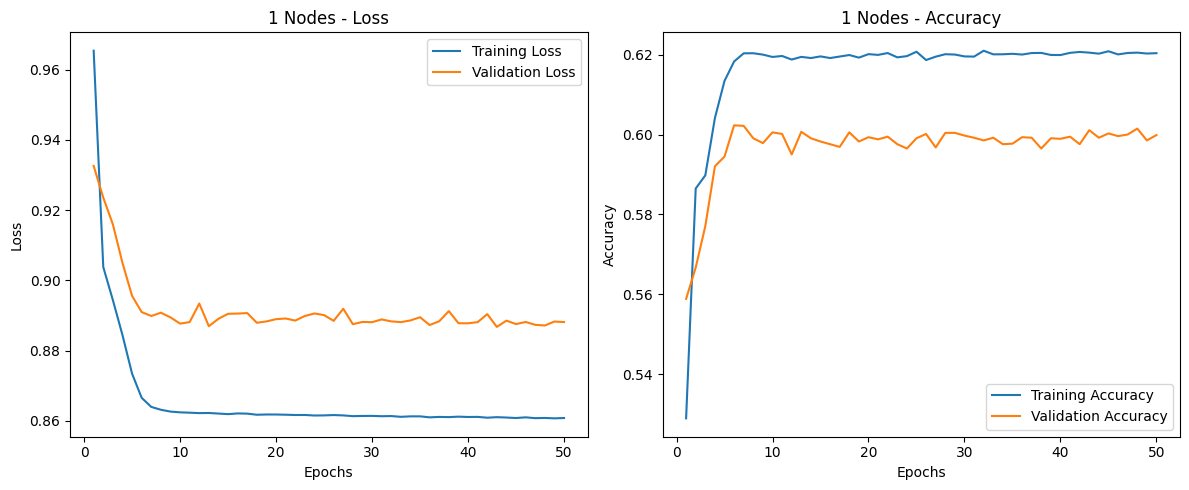


Training with 2 nodes in the hidden layer


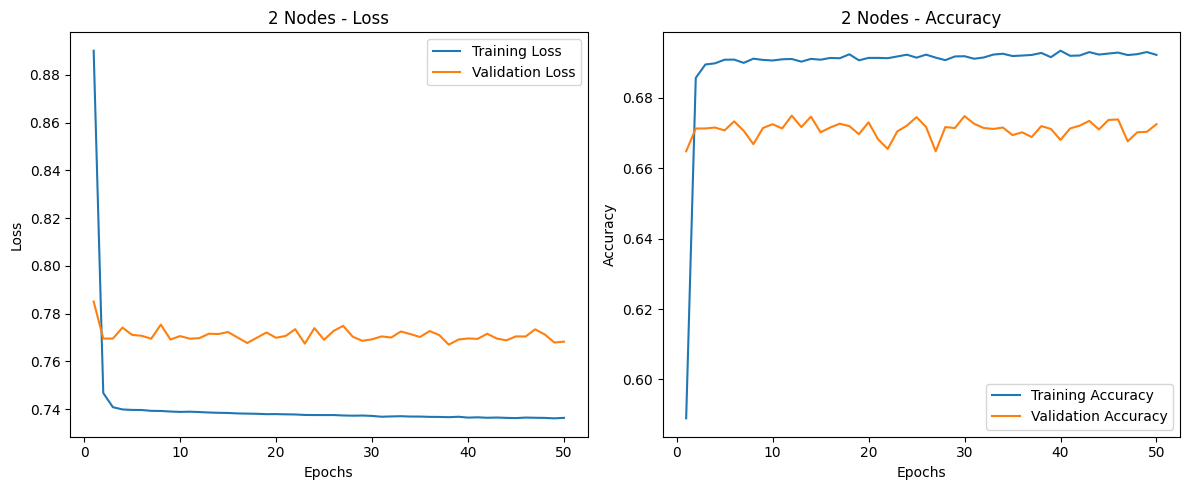


Training with 4 nodes in the hidden layer


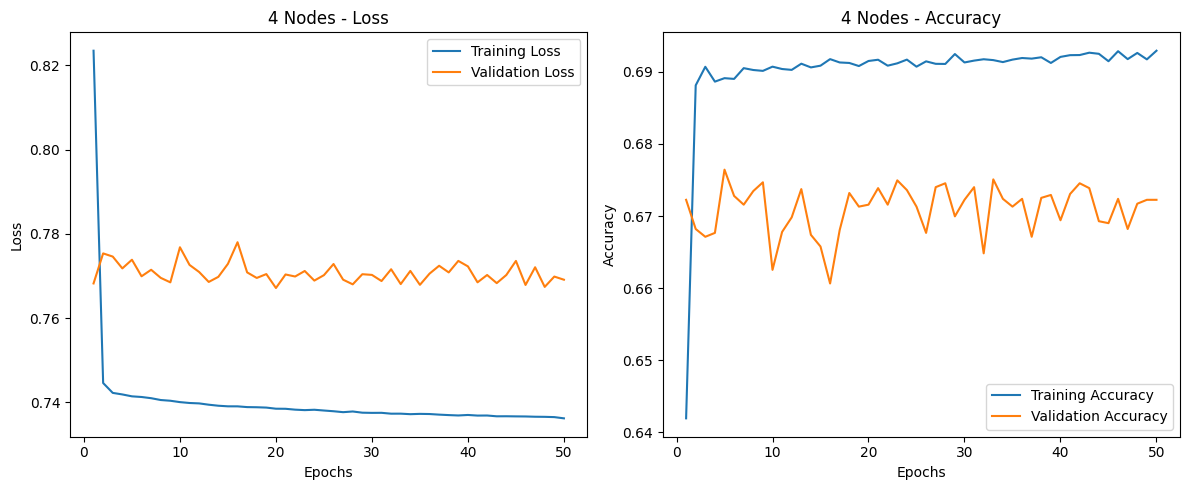


Training with 8 nodes in the hidden layer


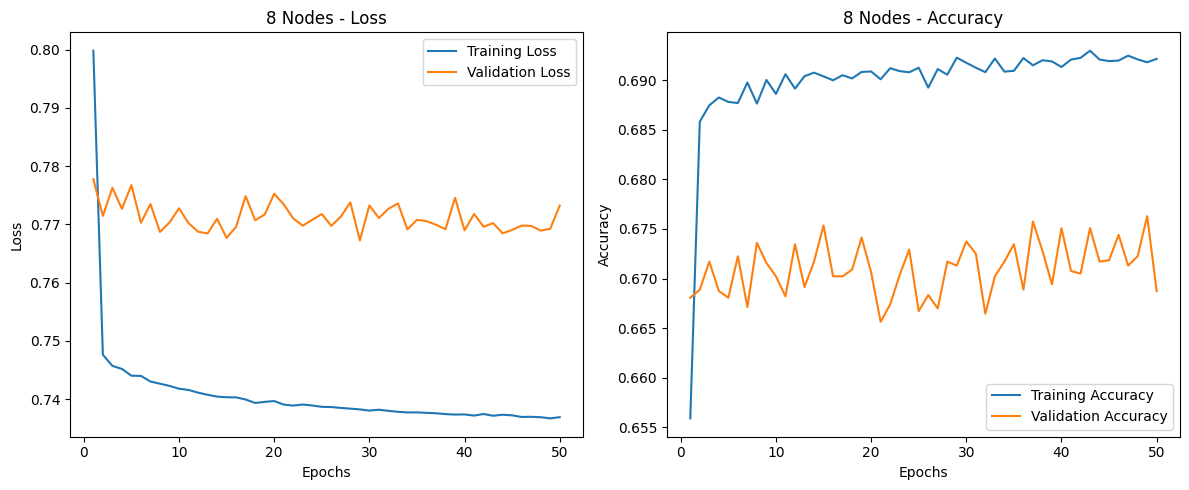


Training with 16 nodes in the hidden layer


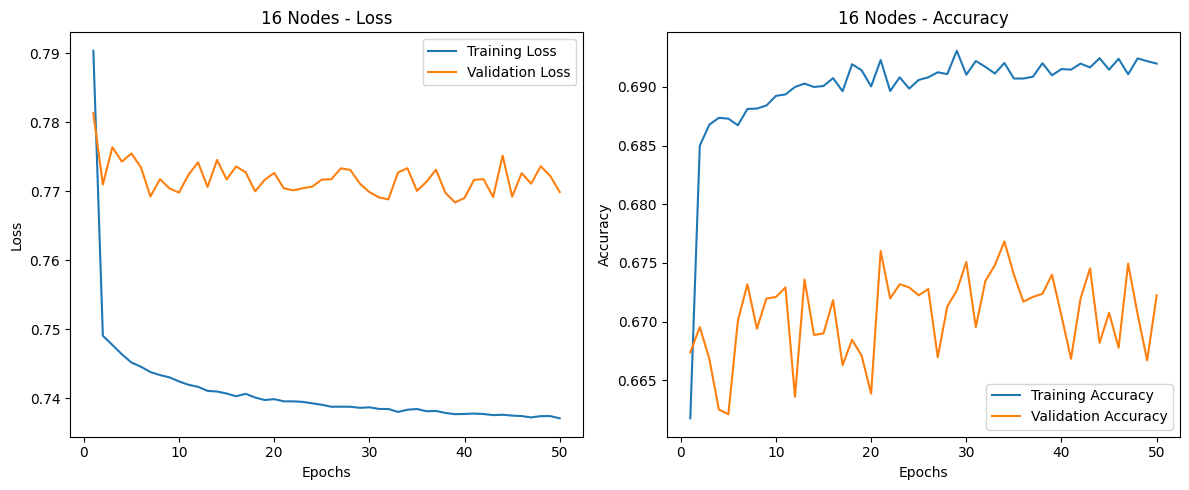


Training with 32 nodes in the hidden layer


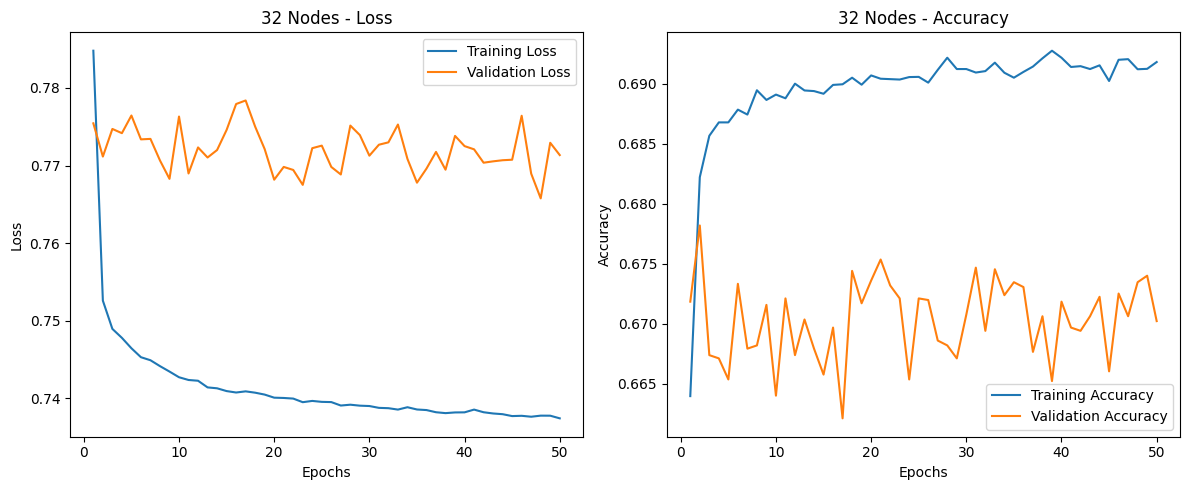


Training with 64 nodes in the hidden layer


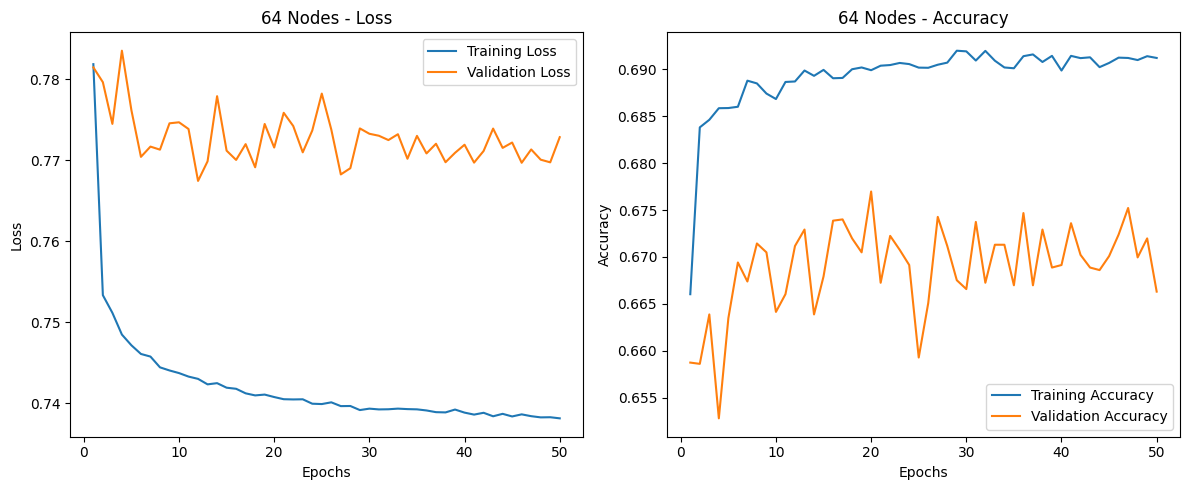


Training with 128 nodes in the hidden layer


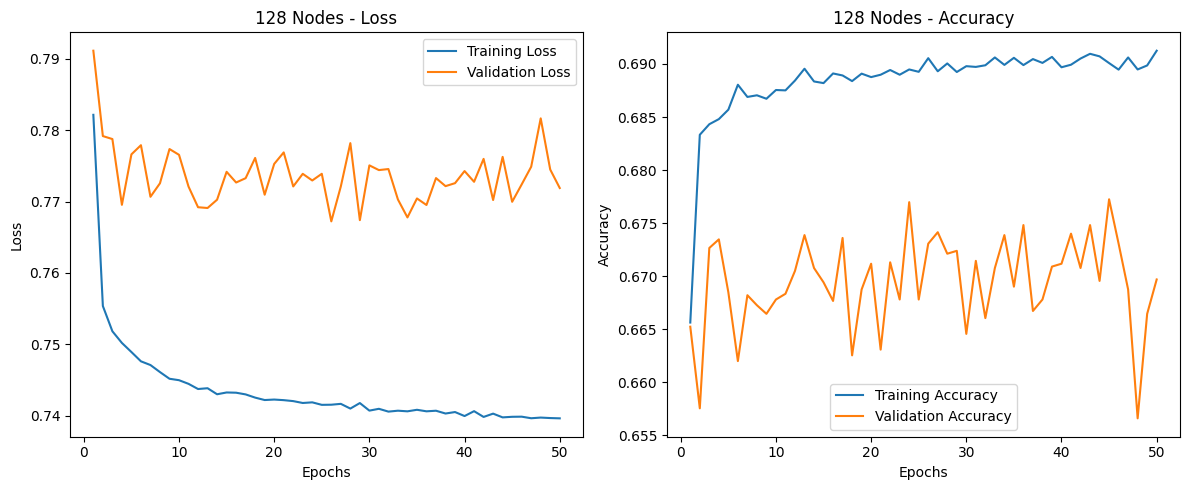


Training with 256 nodes in the hidden layer


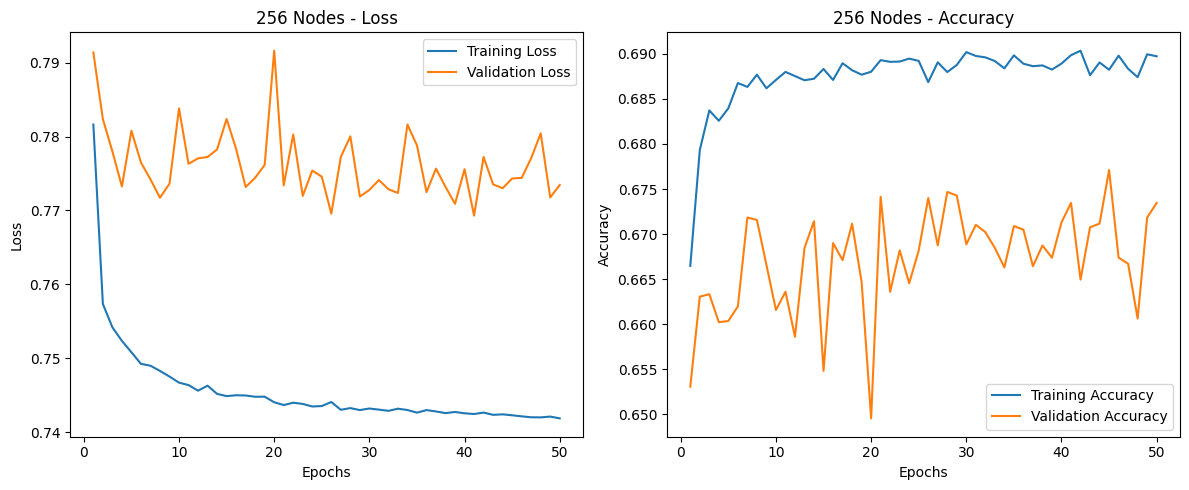


Training with 512 nodes in the hidden layer


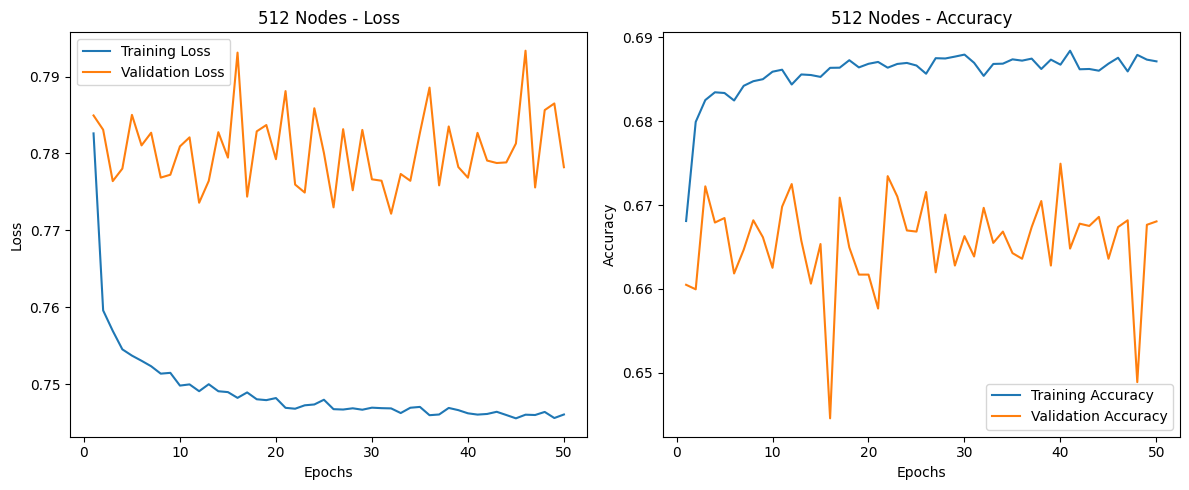

In [12]:
# Initialize lists to store histories for comparison
histories = {}

# Loop through different hidden layer node configurations
for nodes in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    print(f"\nTraining with {nodes} nodes in the hidden layer")
    
    # Define model
    nn_model = Sequential([
        Input(shape=(462,)),              # Input layer
        Dense(nodes),                     # Hidden layer
        Dense(3, activation='softmax')    # Output layer with 3 classes
    ])

    # Compile model
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model and store history
    history = nn_model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
    histories[f'{nodes}_nodes'] = history

    # Plot results
    plot_loss_accuracy(history, title=f'{nodes} Nodes')

For this first experiment, I iterate through different numbers of nodes for the hidden layer to analyze performance, I start with one and progress to 512. So, for each iteration I define my model with the variable number of nodes for the hidden layer, compile the model, train the model and store the history so it can be graphed. I use 50 epochs for each experiment, I started with 5 or 10 as suggested and the model performed well, I then tested with 50 because I tested with 50 for a single node and thought it would be good to keep it consistent for all experiments, the assignment document also says epochs between 40 and 80 worked well, so I thought 50 was a good value to keep working with. For a single node, I can see a sharp decline and then plateau in training and validation loss, and a sharp increase and then plateau for training and validation accuracy. It seems for one node my model is underfitting, the training and validation losses both stabilize at relatively high values, and the gap between training and validation accuracy suggests the model is not capturing sufficient complexity to generalize well. This is likely due to the very low capacity (1 node) which limits its ability to learn patterns in the data. So this is good to know now that I will add more nodes. </br>
With 2 and 4 nodes in the hidden layer, the model shows a slight improvement in training performance, but there’s still a gap between training and validation accuracy, indicating some underfitting. The training loss consistently decreases to low values, while the validation loss remains higher and fluctuates, suggesting the model's limited capacity to capture enough complexity to generalize well. Increasing the node count helped marginally. </br>
I then continued to double the node count all the way until 512 nodes for the hidden layer, and what we can see in the end is that the training loss continued to decrease significantly, indicating the model’s improved capacity to fit the training data. However, the validation loss and accuracy fluctuate widely and show no consistent improvement, which suggests the model may now be overfitting, it captures the training data well but struggles to generalize to new data. </br>
What I am also able to see, is that with 50 training epochs, I was able to eventually see an increase in validation loss for 512 nodes. The validation loss finished as higher than when the model began, so this epoch count was sufficient to show this increase. Overall, this experiment showed me the profound impact of varying the nodes for the hidden layer, I will now move on to the next experiment which is varying the number of layers.


Training with 1 layers and node configuration: [32]


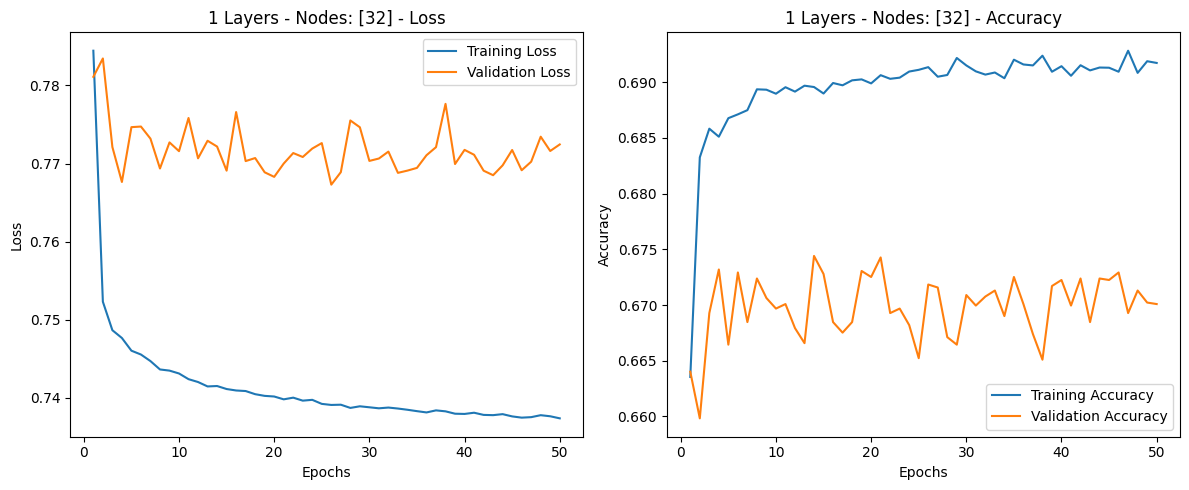


Training with 2 layers and node configuration: [64, 32]


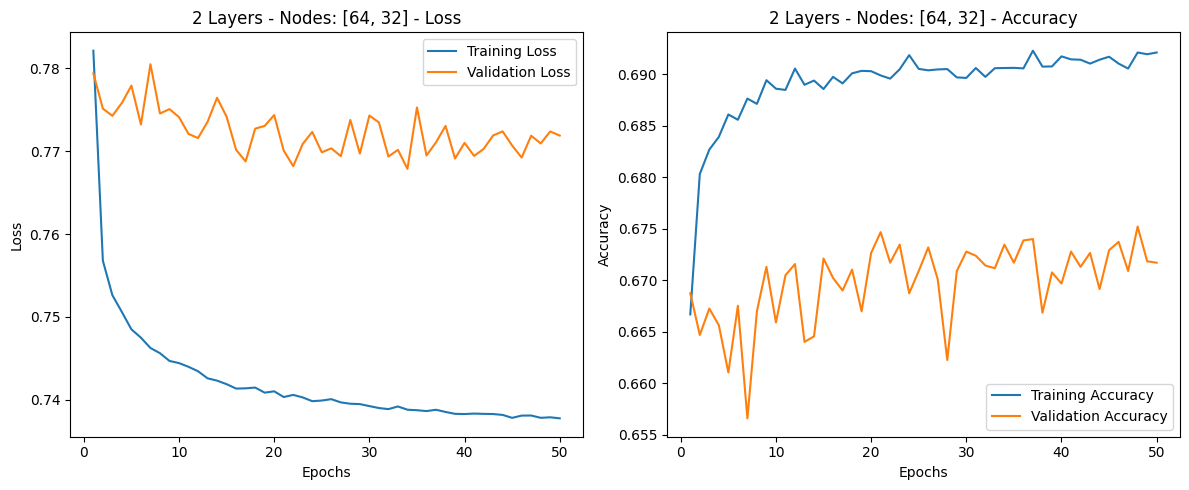


Training with 3 layers and node configuration: [128, 64, 32]


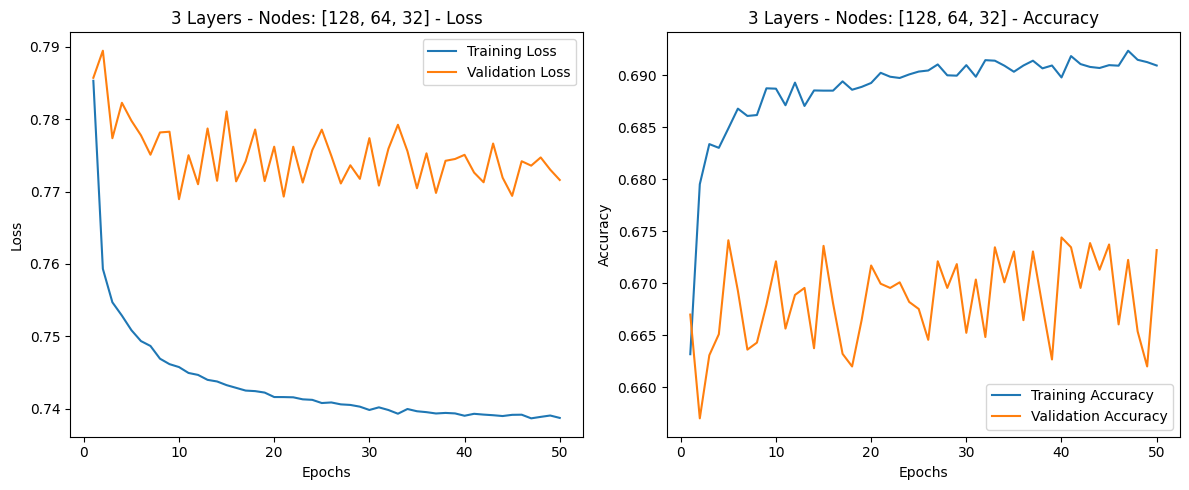


Training with 4 layers and node configuration: [128, 64, 32, 16]


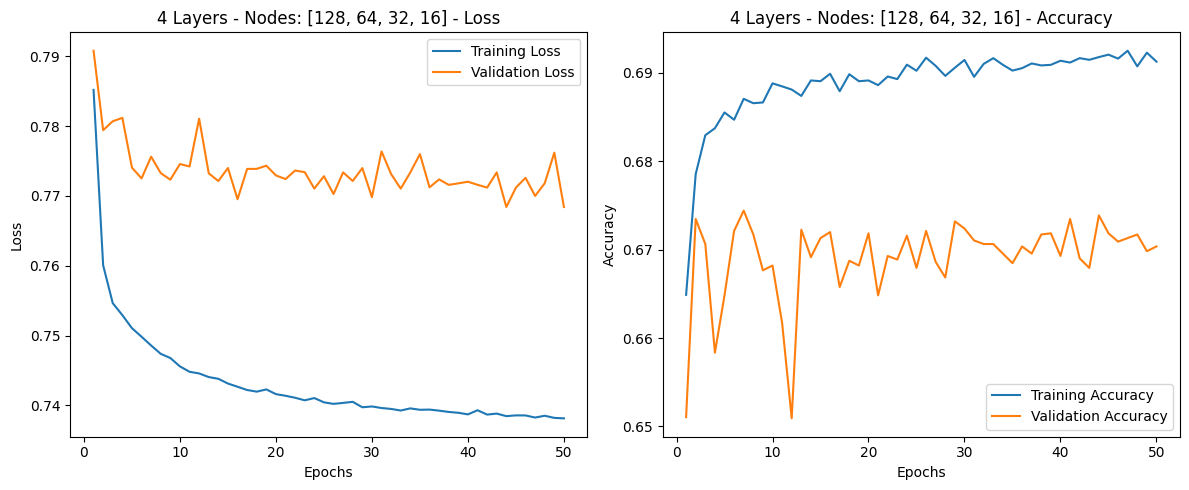


Training with 2 layers and node configuration: [64, 64]


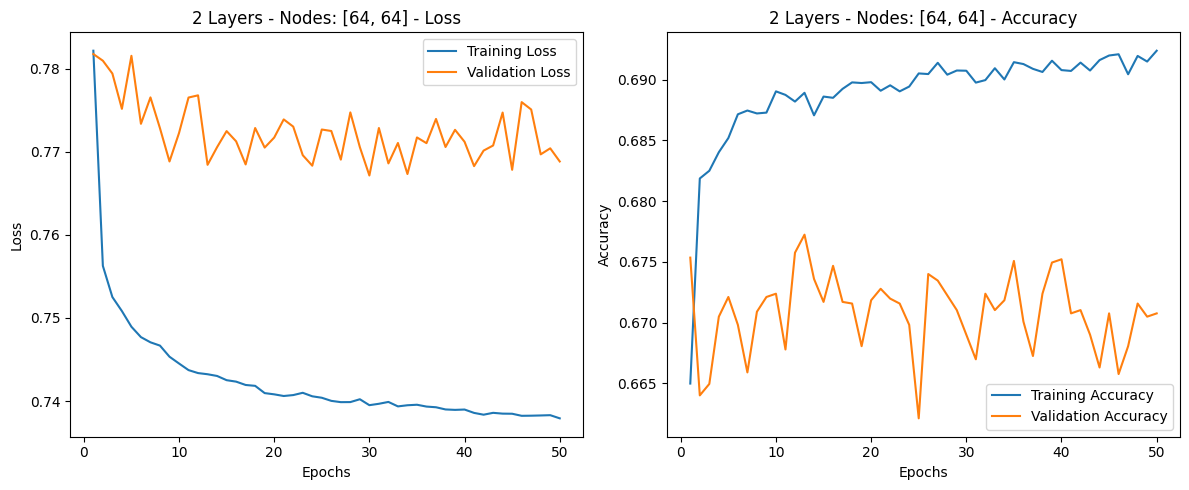


Training with 3 layers and node configuration: [64, 64, 64]


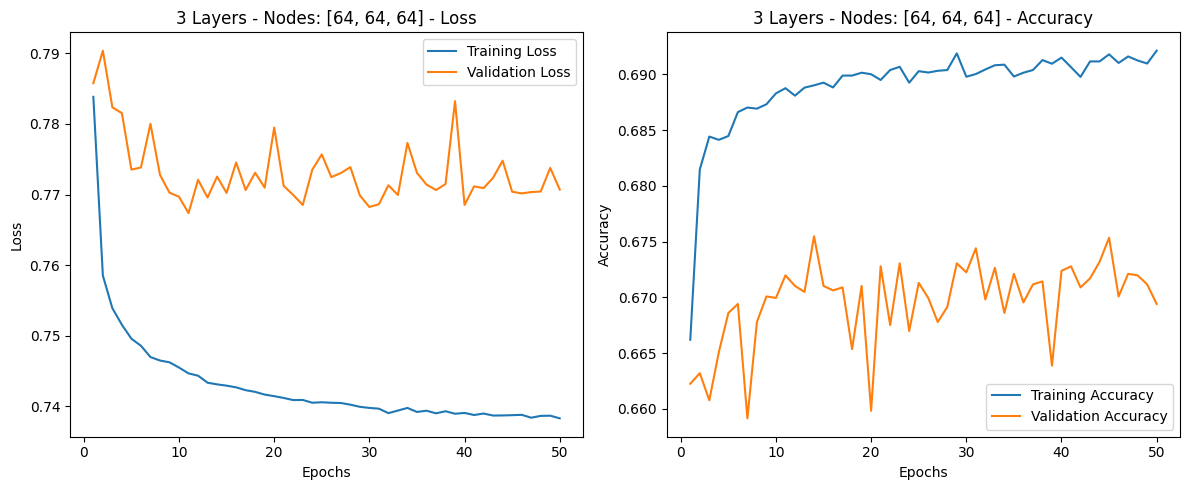


Training with 4 layers and node configuration: [64, 64, 64, 64]


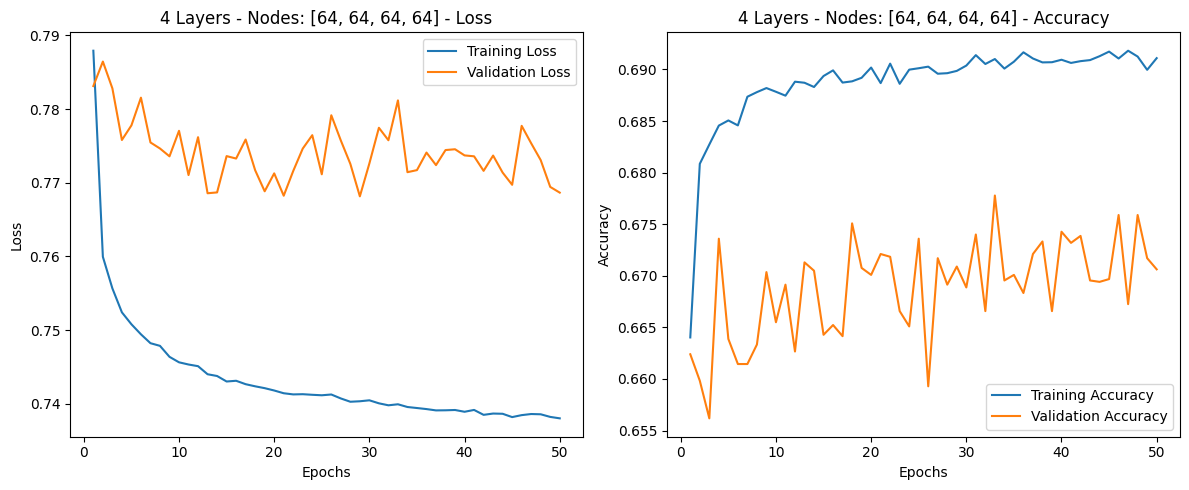

In [10]:
# Initialize lists to store histories for layer comparison
layer_histories = {}

# Define different layer configurations (1 to 4 layers) and node distribution strategies
layer_configs = [
    {'layers': 1, 'nodes': [32]},                # Single layer with 32 nodes
    {'layers': 2, 'nodes': [64, 32]},            # Pyramid: 64 nodes in the first layer, 32 in the second
    {'layers': 3, 'nodes': [128, 64, 32]},       # Pyramid: 128, 64, and 32 nodes
    {'layers': 4, 'nodes': [128, 64, 32, 16]},   # Pyramid: 128, 64, 32, and 16 nodes
    {'layers': 2, 'nodes': [64, 64]},            # Constant: 64 nodes in each of two layers
    {'layers': 3, 'nodes': [64, 64, 64]},        # Constant: 64 nodes in each of three layers
    {'layers': 4, 'nodes': [64, 64, 64, 64]}     # Constant: 64 nodes across four layers
]

# Loop through each layer configuration
for config in layer_configs:
    num_layers = config['layers']
    nodes = config['nodes']
    print(f"\nTraining with {num_layers} layers and node configuration: {nodes}")
    
    # Define the model with variable layers
    nn_model = Sequential([Input(shape=(462,))])  # Input layer
    for node_count in nodes:
        nn_model.add(Dense(node_count))  # Hidden layers
    nn_model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

    # Compile model
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and store the history
    history = nn_model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
    layer_histories[f'{num_layers}_layers_{nodes}'] = history
    
    # Plot results
    plot_loss_accuracy(history, title=f'{num_layers} Layers - Nodes: {nodes}')


For this experiment, I created multiple layer configurations, I used one layer with 32 nodes, and then I added layers up until 4 with a pyramid structure, and then I added nodes until 4 again but with constant nodes in each layer to compare the two. I then loop through each configuration and graph the loss and accuracy results after compiling and fitting the model with the new configuration. I also went with 50 epochs once again to stay consistent with my previous experiment. For the single layer, I can see my training loss sharply decrease and steady out but my validation loss slightly decreases then stays steady, and the training accuracy also sharply increases and steadies out and my validation accuracy slightly increases then steadies out, though a bit eradically. As I increase my layers with the pyramid structure, I see much improved loss and accuracy results for my training set, but almost no change in my validation loss and accuracy, which stays quite eradic. This is a sign of overfitting. As I add my layers with the constant node count, I see almost identical behaviour with improvements in training loss and accuracy, but not much improvement for validation loss and accuracy. So this also leads to overfitting it seems. The model that leads to the most overfitting it seems is the 4 layer pyramid structure, which has very good training loss and accuracy but no real change for the validation loss or accuracy. This is because deeper networks with a high number of parameters can better memorize the training data, leading to increased variance and poor generalization. Training these deeper or wider networks for more epochs, say, beyond 50, would further amplify overfitting. This lets the model continue to learn noise in the training data rather than stopping early before memorizing it. So this experiment has shown me the effect of adding layers to my model. I will now try to create the model so that it has nearly 100% training accuracy.

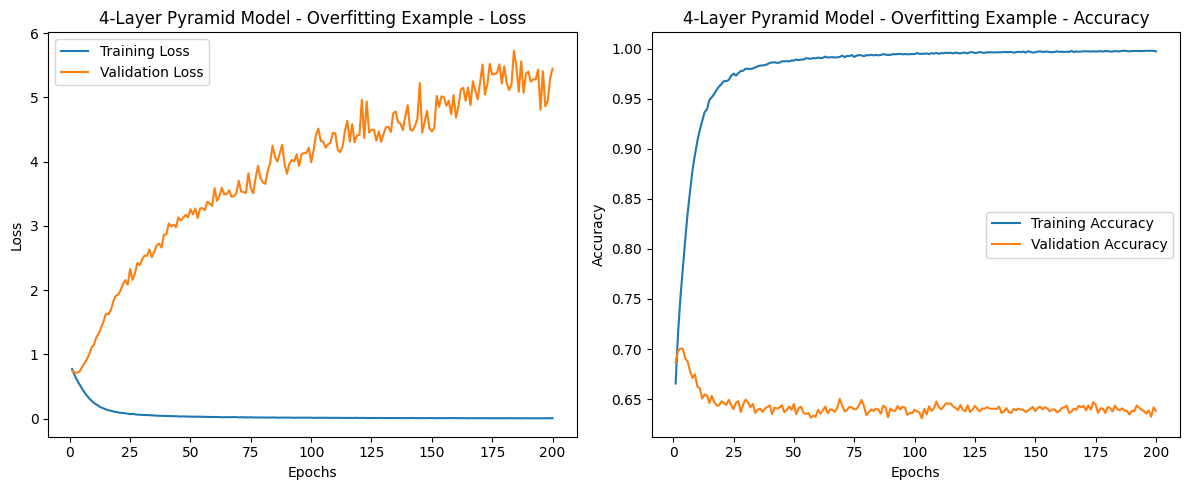

In [15]:
# Set up and train the 4-layer pyramid model with a high number of epochs
pyramid_model = Sequential([Input(shape=(462,))])  # Input layer

# Add pyramid layers
for nodes in [128, 64, 32, 16]:
    pyramid_model.add(Dense(nodes, activation='relu'))

# Output layer for 3 classes
pyramid_model.add(Dense(3, activation='softmax'))

# Compile model
pyramid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model with an increased number of epochs to encourage overfitting
history = pyramid_model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), verbose=0)

# Store history for analysis
layer_histories['4_layer_pyramid_128-64-32-16_overfit'] = history

# Plot training and validation loss and accuracy
plot_loss_accuracy(history, title='4-Layer Pyramid Model - Overfitting Example')


So here, I setup the model with 4 layers and a pyramind structure, I use a relu activation function just for increased performance, and 200 epochs to heavily train the model on the training data. We can see a loss of almost 0 for the training set and a sharply increasing validation loss. We can also see a training accuracy of basically 100% and a steady and low validation accuracy. So this is quite strong overfitting, this happens because the model has effectively memorized the training data, including noise, but cannot generalize well to unseen data in the validation set, leading to massive disparities in the results. Next, I will conduct an experiment with different activation functions.


Training with relu activation function


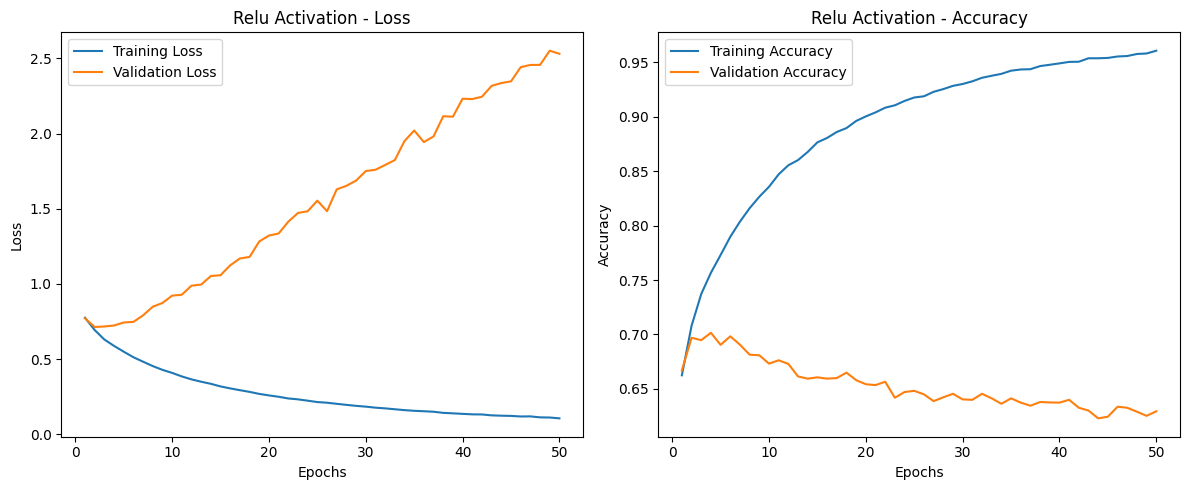


Training with sigmoid activation function


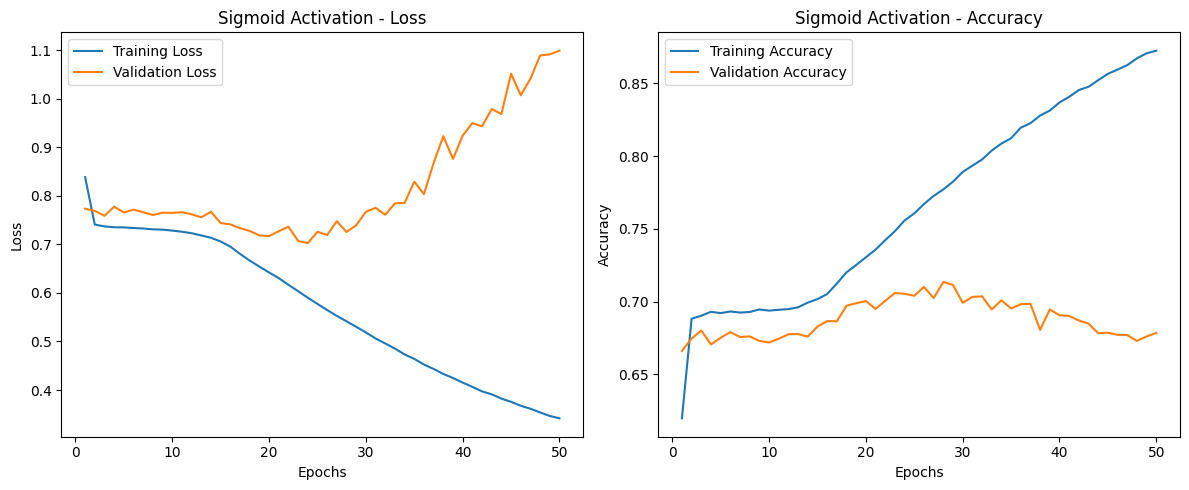

In [11]:
# Initialize dictionary to store histories for each activation function
activation_histories = {}

# Loop through two activation functions: relu and sigmoid
for activation in ['relu', 'sigmoid']:
    print(f"\nTraining with {activation} activation function")
    
    # Define the model with the chosen activation function and 4 layers of 64 nodes each
    nn_model = Sequential([
        Input(shape=(462,)),                          # Input layer
        Dense(64, activation=activation),             # Hidden layer 1
        Dense(64, activation=activation),             # Hidden layer 2
        Dense(64, activation=activation),             # Hidden layer 3
        Dense(64, activation=activation),             # Hidden layer 4
        Dense(3, activation='softmax')                # Output layer
    ])
    
    # Compile the model
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and store history
    history = nn_model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
    activation_histories[f'{activation}_activation'] = history

    # Plot the results
    plot_loss_accuracy(history, title=f'{activation.capitalize()} Activation')


For this experiment, I use the relu and sigmoid activation functions to compare performance, I setup my model with 4 hidden layers, each with 64 nodes for a consistent test of the activation functions, I again use 50 epochs for consistency. I then compile and fit the models and graph the loss and accuracy for each. For relu, the model’s training loss steadily decreases, and the training accuracy climbs towards 100% over the 50 epochs. This shows that the model is learning effectively on the training set. The validation loss, however, increases consistently as the epochs progress, while the validation accuracy gradually drops. This pattern suggests overfitting. The model is learning the training data too well, to the point where it’s not generalizing effectively on the validation set. For sigmoid, the training loss decreases more slowly than with relu, and the training accuracy increases gradually, plateauing below 85%. The validation loss slightly fluctuates but trends upward overall, and the validation accuracy remains relatively flat after an initial rise, hovering around 65%-70%. Sigmoid activation functions are known for saturating, which can cause the gradients to diminish as they propagate through the network. This limits the learning capacity of the model, especially in deep networks. So, the model is not fitting the training data as effectively as with relu, and it also doesn’t overfit as drastically. However, the overall performance is lower, indicating that Sigmoid might not be ideal for this architecture or dataset. Next I will use regularization in an attempt to prevent this consistent overfitting problem.


Training with L2 regularization value of 0.01


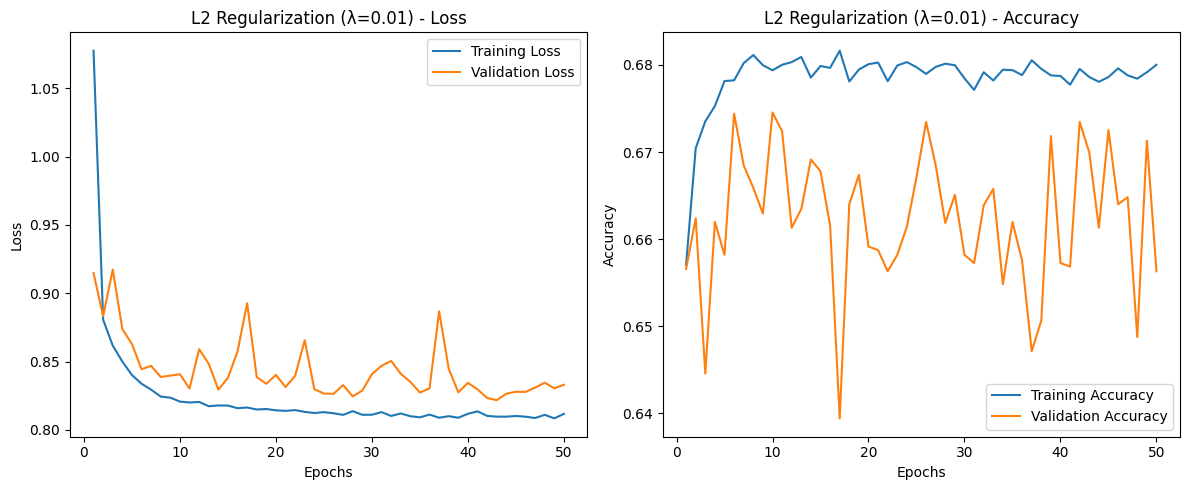


Training with L2 regularization value of 0.001


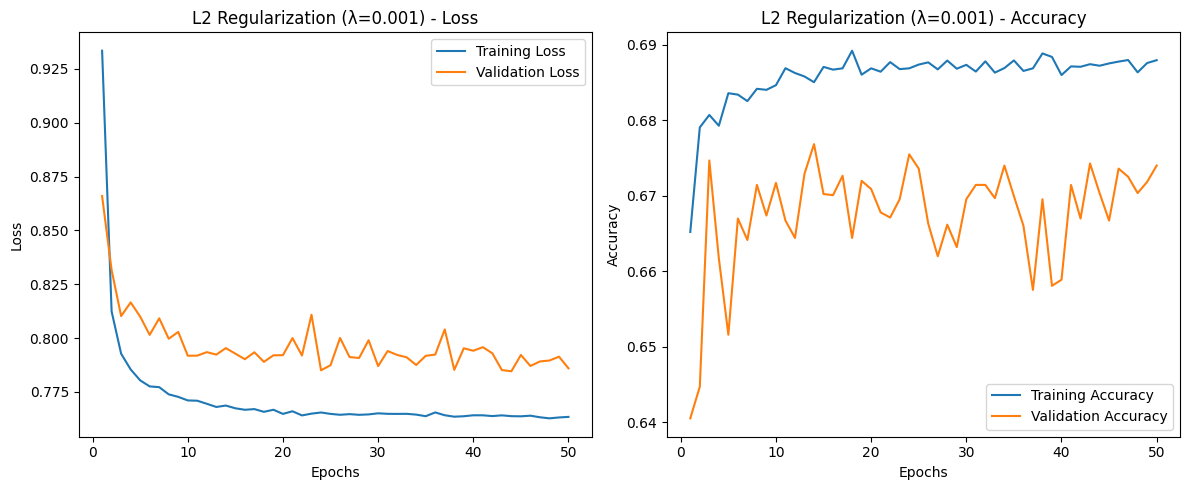


Training with L2 regularization value of 0.0001


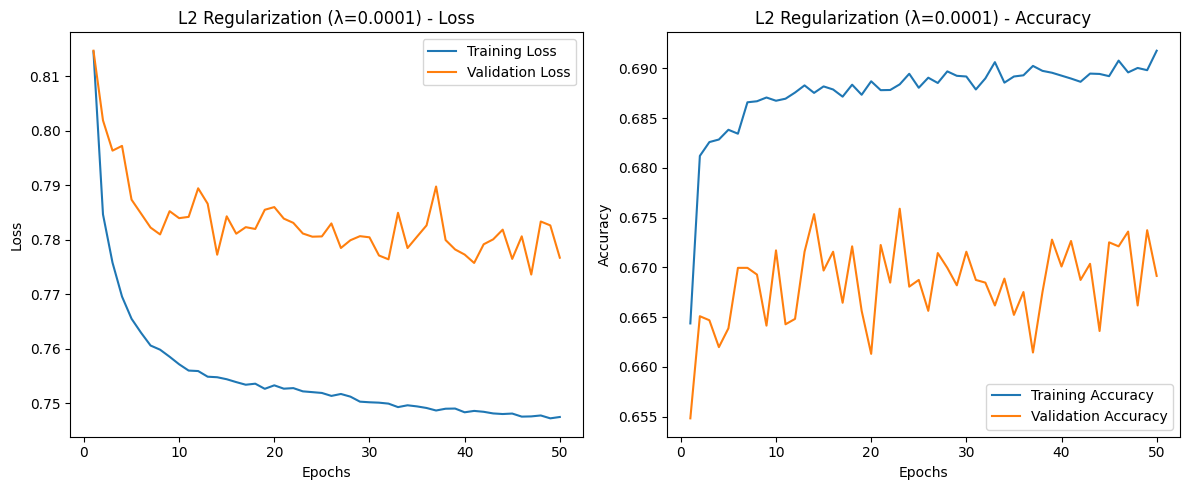

In [13]:
# Initialize dictionary to store histories for L2 regularization
l2_histories = {}

# Loop through different L2 regularization values
for l2_value in [0.01, 0.001, 1e-4]:
    print(f"\nTraining with L2 regularization value of {l2_value}")
    
    # Define model with L2 regularization
    nn_model = Sequential([
        Input(shape=(462,)),                         # Input layer
        Dense(64, kernel_regularizer=l2(l2_value)),  # Hidden layer 1
        Dense(64, kernel_regularizer=l2(l2_value)),  # Hidden layer 2
        Dense(64, kernel_regularizer=l2(l2_value)),  # Hidden layer 3
        Dense(64, kernel_regularizer=l2(l2_value)),  # Hidden layer 4
        Dense(3, activation='softmax')               # Output layer
    ])
    
    # Compile model
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model and store history
    history = nn_model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
    l2_histories[f'l2_{l2_value}'] = history
    
    # Plot results
    plot_loss_accuracy(history, title=f'L2 Regularization (λ={l2_value})')


For this first experiment, I add a penalty to the loss function, an l2 penalty on all my layers. I used 4 layers with 64 nodes each, and 50 epochs again. After compiling and fitting the models, it seems the best performer was a loss value of 0.001, this was the second configuration. It was the one that steadily decreased the training and validation loss, and increases the training and validation accuracy by quite a lot. This penalty value was likely effective because it provided enough regularization to reduce the complexity of the model without being overly restrictive. This balance allowed the model to generalize better by limiting overfitting, while still preserving important patterns in the data for accurate predictions. Now I will compare my results with and without regularization to show that I have reduced overfitting.

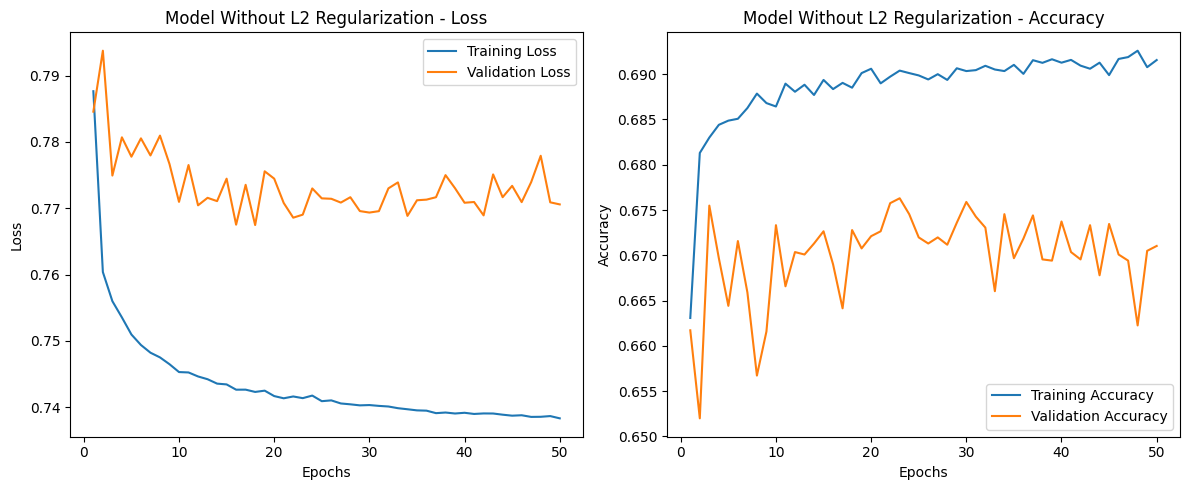

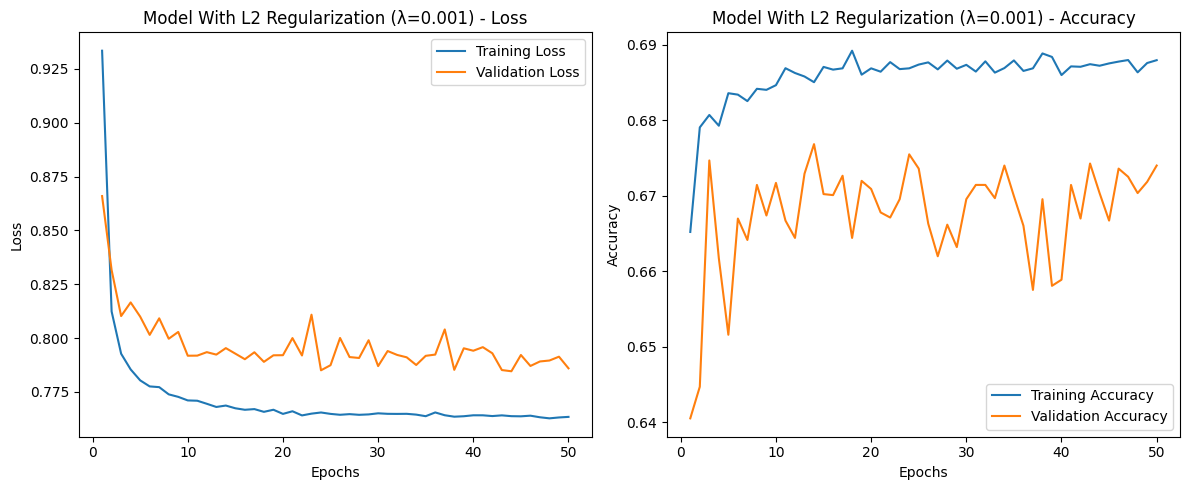

In [17]:
# Initialize dictionary to store histories for the model without L2 regularization
no_l2_history = {}

# Define model without L2 regularization
nn_model_no_l2 = Sequential([
    Input(shape=(462,)),            # Input layer
    Dense(64,),    # Hidden layer 1
    Dense(64,),    # Hidden layer 2
    Dense(64,),    # Hidden layer 3
    Dense(64,),    # Hidden layer 4
    Dense(3, activation='softmax')   # Output layer
])

# Compile model without L2 regularization
nn_model_no_l2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model without L2 regularization and store history
no_l2_history = nn_model_no_l2.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)

# Store history for comparison
layer_histories['no_l2'] = no_l2_history

# Plot results for model without L2 regularization
plot_loss_accuracy(no_l2_history, title='Model Without L2 Regularization')

# Plot results for the L2 regularized model (with λ=0.001)
plot_loss_accuracy(l2_histories['l2_0.001'], title='Model With L2 Regularization (λ=0.001)')


Here I setup a model with no regularization and my regularization model and compare the graphs, with regularization I can see my validation loss and validation accuracy stay much tighter to my training lines, with a validation loss that steadily decreases and a validation accuracy that increases, indicating that it is able generalize better than with no regularization. It should be noted that overfitting is not completely eliminated but it has been slightly improved here. Next I will test with dropout layers.


Training with Dropout rate: 0.25


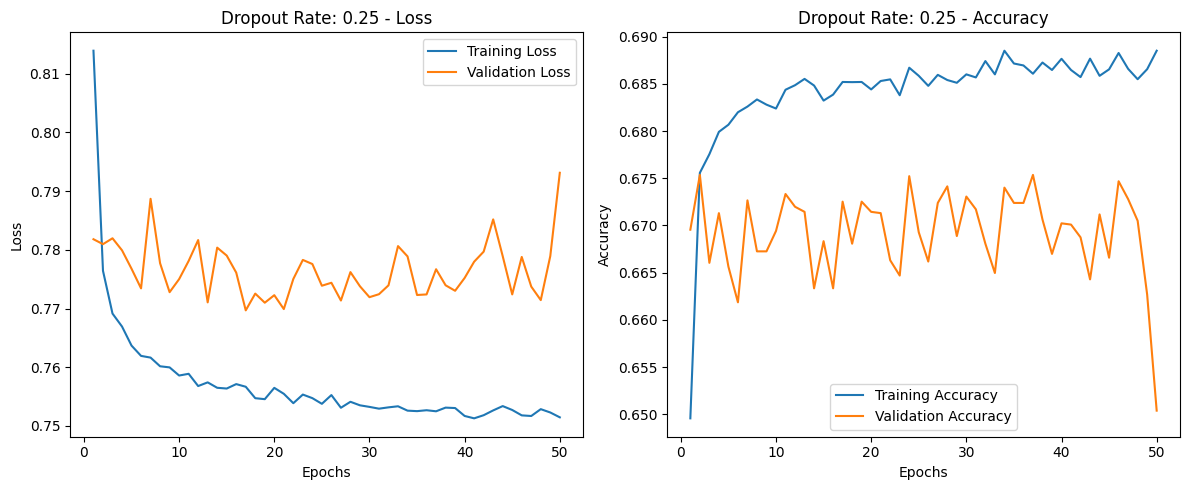


Training with Dropout rate: 0.5


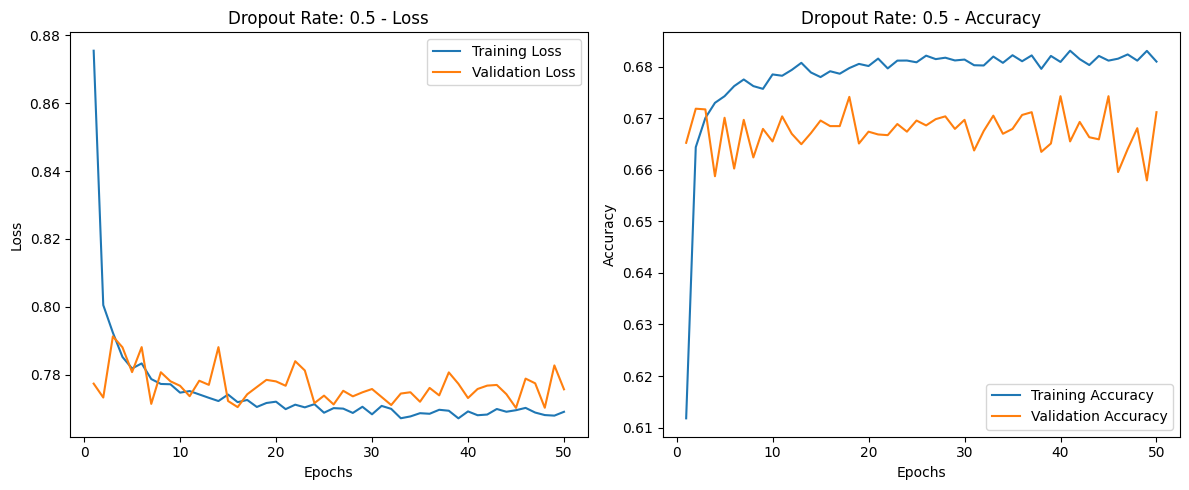

In [19]:
# Initialize dictionary to store histories for dropout experiments
dropout_histories = {}

# Define dropout rates to experiment with
dropout_rates = [0.25, 0.5]

# Loop through each dropout rate
for rate in dropout_rates:
    print(f"\nTraining with Dropout rate: {rate}")
    
    # Define the model with dropout layers
    nn_model_dropout = Sequential([
        Input(shape=(462,)),                   # Input layer
        Dense(64,),          # Hidden layer 1
        Dropout(rate),                         # Dropout layer
        Dense(64,),          # Hidden layer 2
        Dropout(rate),                         # Dropout layer
        Dense(64,),          # Hidden layer 3
        Dropout(rate),                         # Dropout layer
        Dense(64,),          # Hidden layer 4
        Dense(3, activation='softmax')         # Output layer
    ])
    
    # Compile model
    nn_model_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and store the history
    history = nn_model_dropout.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
    dropout_histories[f'dropout_{rate}'] = history
    
    # Plot results
    plot_loss_accuracy(history, title=f'Dropout Rate: {rate}')

In this experiment I test a 4 layer model with 64 nodes each, with 4 dropout layers at rates of 0.25 and 0.5. I again use 50 epochs, after compiling and fitting the models, I see that for 0.25 there isn't much improvement, the validation loss is still quite detached from the training loss and even spikes at the end. For the validation accuracy, it is also detached from the training accuracy and even has a massive dip at the end. For 0.5 however, we see large improvements. The validation loss closely follows the training loss and is relatively low, and the validation accuracy stays close to the training accuracy and is relatively high. This shows that higher dropout rates can help reduce overfitting by preventing the model from becoming too reliant on specific neurons. So this experiment has been good at showing how dropout rate can mitigate overfitting. I will now create a summary graph.

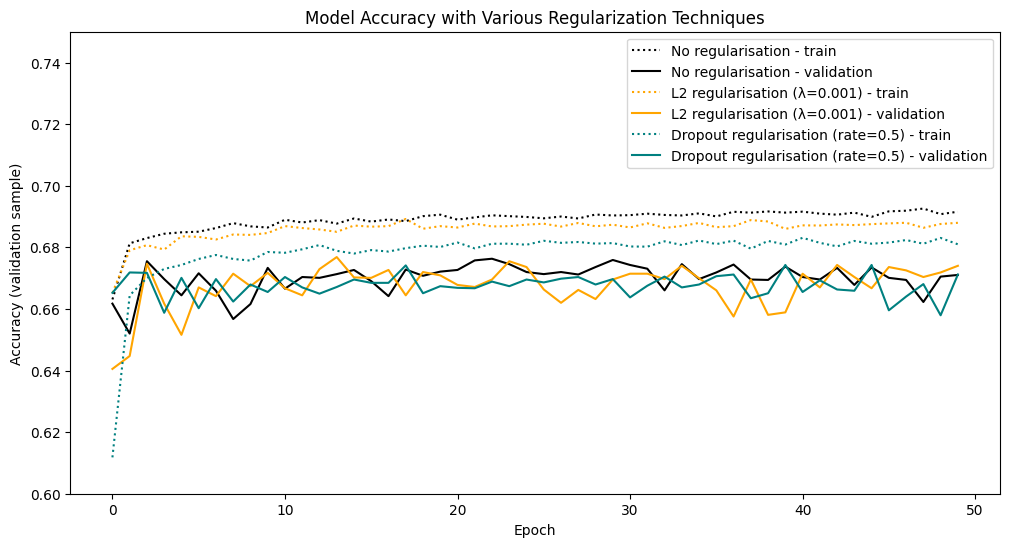

In [24]:
# Helper function to plot accuracy over epochs
def plot_accuracy_over_epochs(histories, title, reg_labels, linestyle_options, color_options):
    plt.figure(figsize=(12, 6))
    for i, (label, history) in enumerate(histories.items()):
        # Training accuracy
        plt.plot(history.history['accuracy'], linestyle=linestyle_options['train'], color=color_options[i], label=f'{label} - train')
        # Validation accuracy
        plt.plot(history.history['val_accuracy'], linestyle=linestyle_options['validation'], color=color_options[i], label=f'{label} - validation')
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (validation sample)")
    plt.title(title)
    plt.ylim(0.6, 0.75)
    plt.legend()
    plt.show()

# Dictionary for storing line styles and colors
linestyle_options = {'train': 'dotted', 'validation': 'solid'}
color_options = ['black', 'orange', 'teal', 'cyan', 'brown', 'yellowgreen']

# Combine histories from L2 and Dropout experiments
selected_histories = {
    'No regularisation': no_l2_history,
    'L2 regularisation (λ=0.001)': l2_histories['l2_0.001'],
    'Dropout regularisation (rate=0.5)': dropout_histories['dropout_0.5']
}

# Define line style and color options for the two configurations
linestyle_options = {'train': 'dotted', 'validation': 'solid'}
color_options = ['black', 'orange', 'teal']

# Plot combined accuracy
plot_accuracy_over_epochs(selected_histories, "Model Accuracy with Various Regularization Techniques", list(selected_histories.keys()), linestyle_options, color_options)


From this summary graph we can see the results with no regulaization, l2 with 0.001 and the dropout with rate of 0.5 with the training and validation sets. I ran all my experiments with 50 epochs, using 200-300 epochs would've let to overall higher accuracies, whereas my scale is capped at 0.75. However, this graph still shows the different performances of the experiments quite well and is a good way to visualize each one. Next I will run an experiment with early stopping.

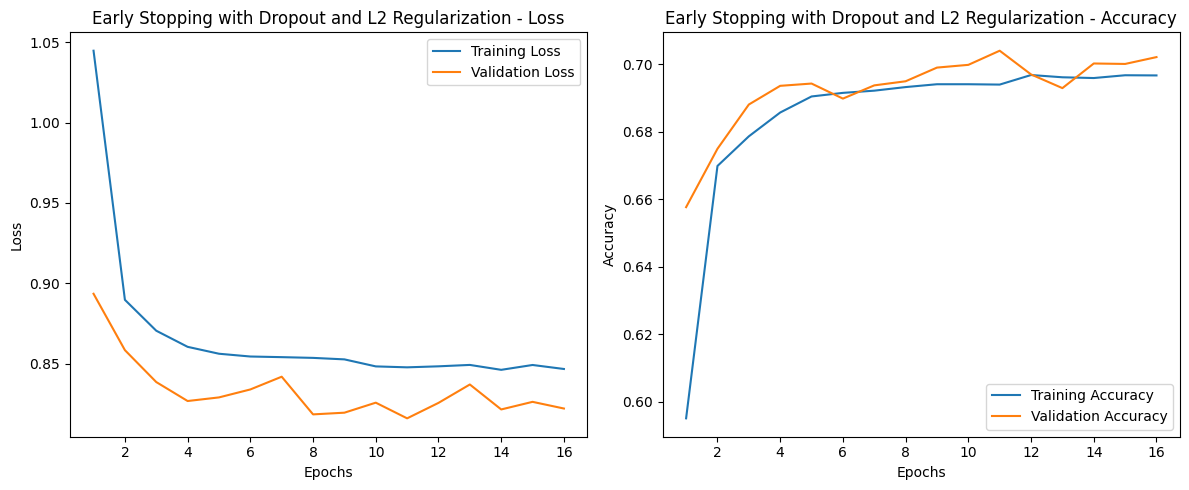

Optimal number of epochs: 16


In [25]:
# Set up early stopping to monitor validation loss with patience
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore weights from the best epoch
)

# Define model with chosen configuration
nn_model = Sequential([
    Input(shape=(462,)),                                  # Input layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # First hidden layer
    Dropout(0.5),                                         # Dropout layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),   # Second hidden layer
    Dropout(0.5),                                         # Dropout layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),   # Third hidden layer
    Dropout(0.5),                                         # Dropout layer
    Dense(3, activation='softmax')                        # Output layer for 3 classes
])

# Compile model
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model with early stopping
history = nn_model.fit(
    X_train, y_train,
    epochs=50,                          # Set a high number of epochs
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],         # Add early stopping callback
    verbose=0
)

# Plot loss and accuracy to determine optimal epochs
plot_loss_accuracy(history, title='Early Stopping with Dropout and L2 Regularization')

# Find optimal number of epochs
optimal_epochs = len(history.history['loss'])
print(f"Optimal number of epochs: {optimal_epochs}")

In this experiment, I setup early stopping to monitor validation loss, with a patience of 5, and to restore best weights. I then create my model with 3 layers with a pyramind structure, with the relu activation function and dropout layers with a rate of 0.5. I found this will be a good model to test with. I then set it initially to 50 epochs and compile and fit the model. I can see that the optimal number of epochs here is 16. The combination of dropout (0.5) and L2 regularization (0.001) helps prevent the model from fitting too closely to the training data. These techniques effectively limit the model's complexity, reducing the chance of overfitting and encouraging generalization. Early in training, the model likely learned the most significant patterns in the data quickly. After a certain point here, around 16 epochs—further training didn’t yield better validation results, suggesting that it had already captured the main patterns and relationships in the data. The early stopping callback is configured to detect when the validation loss stops improving. At around 16 epochs, validation loss likely plateaued or started to increase slightly, indicating diminishing returns on further training. So stopping at 16 epochs allowed the model to retain its best performance on the validation set, avoiding overfitting and excessive memorization of the training data.

#### 9. Model Comparison
Here I will evaluate my models on the test set to see how they perform.

In [34]:
# Ensure data is in NumPy array format
X_train = np.array(X_train)
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)
X_valid = np.array(X_valid)
X_valid_scaled = np.array(X_valid_scaled)
y_valid = np.array(y_valid)

# Dummy model setup and evaluation (assuming `dummy_model` is already defined)
dummy_clf = DummyClassifier(strategy="most_frequent")

print("Evaluating Dummy Model:")
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_test)
print("Dummy Model Performance:")
print(classification_report(y_test, dummy_preds, digits=4))

# Evaluate the baseline model on the test set
baseline_clf = LogisticRegression(solver='saga', penalty='l1', max_iter=100, tol=0.01)  

print("\nEvaluating Baseline Model:")
baseline_clf.fit(X_train, y_train)
baseline_preds = baseline_clf.predict(X_test)  # Use the best-performing baseline model
print("Baseline Model Performance:")
print(classification_report(y_test, baseline_preds, digits=4))

print("Evaluating Baseline Model on Scaled Data:")
baseline_clf_scaled = LogisticRegression(solver='saga', penalty='l1', max_iter=100, tol=0.01)
baseline_clf_scaled.fit(X_train_scaled, y_train)
baseline_preds_scaled = baseline_clf_scaled.predict(X_test_scaled)
print("Baseline Model Performance on Scaled Data:")
print(classification_report(y_test, baseline_preds_scaled, digits=4))

# Neural network setup 
final_nn_model = Sequential([
    Input(shape=(462,)),                                  # Input layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # First hidden layer
    Dropout(0.5),                                         # Dropout layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),   # Second hidden layer
    Dropout(0.5),                                         # Dropout layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),   # Third hidden layer
    Dropout(0.5),                                         # Dropout layer
    Dense(3, activation='softmax')                        # Output layer for 3 classes
])

# Evaluate the neural network model on the test set
print("\nEvaluating Neural Network Model:")
final_nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_nn_model.fit(X_train, y_train, epochs=16, validation_data=(X_valid, y_valid), verbose=0)
nn_preds = np.argmax(final_nn_model.predict(X_test), axis=1)  # Convert probabilities to class predictions
print("Neural Network Model Performance:")
print(classification_report(y_test, nn_preds, digits=4))

print("\nEvaluating Neural Network Model on Scaled Data:")
final_nn_model_scaled = Sequential([
    Input(shape=(462,)),                 # Input layer 
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # First hidden layer
    Dropout(0.5),                                            # Dropout layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),   # Second hidden layer
    Dropout(0.5),                                            # Dropout layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),   # Third hidden layer
    Dropout(0.5),                                            # Dropout layer
    Dense(3, activation='softmax')                           # Output layer for 3 classes
])

final_nn_model_scaled.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_nn_model_scaled.fit(X_train_scaled, y_train, epochs=16, validation_data=(X_valid_scaled, y_valid), verbose=0)

nn_preds_scaled = np.argmax(final_nn_model_scaled.predict(X_test_scaled), axis=1)  # Get predicted classes
print("Neural Network Model Performance on Scaled Data:")
print(classification_report(y_test, nn_preds_scaled, digits=4))

Evaluating Dummy Model:
Dummy Model Performance:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2528
           1     0.0000    0.0000    0.0000      1852
           2     0.4106    1.0000    0.5821      3051

    accuracy                         0.4106      7431
   macro avg     0.1369    0.3333    0.1940      7431
weighted avg     0.1686    0.4106    0.2390      7431


Evaluating Baseline Model:
Baseline Model Performance:
              precision    recall  f1-score   support

           0     0.7373    0.7836    0.7597      2528
           1     0.7064    0.5572    0.6230      1852
           2     0.7006    0.7539    0.7262      3051

    accuracy                         0.7150      7431
   macro avg     0.7147    0.6982    0.7030      7431
weighted avg     0.7145    0.7150    0.7119      7431

Evaluating Baseline Model on Scaled Data:
Baseline Model Performance on Scaled Data:
              precision    recall  f1-score   su

Here I run my dummy model, my baseline model with the optimal parameters of solver='saga', penalty='l1', max_iter=100, tol=0.01, and my neural network with what I have deemed to be the best setup with 3 layers and a pyramid structure, a dropout layer for each layer at a rate of 0.5, the relu activation function and an l2 regularization value of 0.001, this setup I believe will do the best to reduce overfitting by not having the full 4 layers, the pyramid structure performed virtually the same as the constant structure, the dropout layer at each layer performed very well with a rate of 0.5, the relu activation function performed better than sigmoid, and the l2 regularization of 0.001 proved optimal as well. For my baseline model and neural network, I ran a second experiment with scaled data. I scaled the train, test and valid sets for X earlier in the assignment, and will also see if this improves performance at all for these two models. </br> 
Looking at the results, I can see that the results from the evaluation of the dummy, baseline, and neural network models indicate significant differences in performance across the various classifiers. The dummy classifier, which predicts the most frequent class, achieved an overall accuracy of approximately 41%, largely driven by its reliance on the most abundant class (class 2) in the dataset. This model's precision, recall, and F1-score for classes 0 and 1 were negligible, highlighting its ineffectiveness in classifying less frequent classes and emphasizing the need for more sophisticated approaches. </br>
In contrast, the baseline model, the Logistic Regression classifier, showed a marked improvement, achieving an accuracy of about 71.5% on the original features and 71.2% when using scaled data. This model showed solid performance across the three classes, particularly excelling in class 0 with a precision of 0.7373 and a recall of 0.7836. However, its performance in class 1 was less impressive, indicating potential challenges in distinguishing this class from others. The F1-scores for the baseline model were balanced, especially for class 2, where it scored 0.7262, reflecting the model's overall reliability. </br>
The neural network, which was designed with a pyramid structure and used dropout layers for regularization, achieved the highest overall accuracy of approximately 73.9% on the original features and 73.4% on the scaled data. Its precision and recall for class 0 were strong, with an F1-score of 0.7983, but it faced similar challenges as the baseline model in class 1, with an F1-score of 0.6404. Notably, the neural network's performance was competitive, showcasing its ability to learn complex relationships in the data, although it did not significantly surpass the baseline model in terms of class 1 classification. </br>
One thing to note as well is that the scaled data did nothing to improve performance, for both models it actually hindered performance, showing that scaling the columns in this case was not necessary. </br>
Based on this analysis, the recommended approach would be to choose the neural network model for its superior overall accuracy and ability to handle complex data patterns, while also considering the baseline logistic regression model as a backup due to its straightforward interpretability and relatively strong performance, especially in class 0. The neural network's slightly better F1-scores and overall accuracy suggest it may be more robust in real-world applications where a balanced performance across classes is crucial. However, further tuning and potential enhancements to the neural network could be pursued to improve its handling of class 1, ensuring that it can more effectively differentiate between all classes. So, a combination of the neural network for its learning capacity and the baseline model for its reliability could serve well in operational settings.

--------------------------------------------------------------------------

### References
[Matplotlib Pyplot Documentation](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)<br/>
[Numpy User Guide](https://numpy.org/devdocs/user/)<br/>
[Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html) <br/>
[Sklearn Dummy Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)<br/>
[Sklearn Linear Model Documentation](https://scikit-learn.org/stable/modules/linear_model.html)<br/>
[Sklearn Metrics Documentation](https://scikit-learn.org/stable/api/sklearn.metrics.html)<br/>
[Sklearn Model Selection Documentation](https://scikit-learn.org/1.5/api/sklearn.model_selection.html)<br/>
[Sklearn Preprocessing Documenation](https://scikit-learn.org/1.5/modules/preprocessing.html)<br/>
[Tensorflow Keras Callbacks Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)<br/>
[Tensorflow Keras Layers Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Layer)<br/>
[Tensorflow Keras Models Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model)<br/>
[Tensorflow Keras Regularizers Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Regularizer)<br/>
<br/>
Some of my reference came from my own first and second assignments since some of the techniques were able to be used for this assignment as well. For the newer concepts I referred to the documentation and the course lecture notes to see how to implement them. 